## Introduction

Influence and polarity in social networks are both areas of increased research in recent years. The question we want to investigate is  - do the most popular 
users in a subreddit reflect the sentiment of the subreddit they are in? To answer this question, we will use Pushift's API to gather Reddit data from a series of subreddits. We selected the set of subreddits based on public perception of their polarity, selecting examples of both positive, negative, and neutral subreddits. Our hypothesis is that the most popular users in the subreddit would tend to match the polarization of the subreddit. That is to say, in a highly positively polarized subreddit, the most popular users would be highly positively polarized. If our hypothesis is correct and the polarity of the most popular users is positively correlated to the polarity of the subreddit, this could suggest that the most popular may have an effect on the polarity of the subreddit as a whole.

To explore this hypothesis and answer our initial question, we have two distinct steps that we must accomplish. The first step is to construct the network of interactions in the subreddit. To do this, we will be building a weighted and directed graph where users are nodes and edges are directed from the source user that comments on the target users post or comment (in the event of nested comments). This network will allow us to identify the most popular users in the network according to two traditional network metrics. We will be using both node degree, that is the number of connection that a user has to and from other users, and betweeness centrality, which is a measure of the how likely one users is to be a part of the shortest paths between all of the other pairs of users in the network. 

The second step is to collect all of the user comments in the same period of time to conduct sentiment analysis to find each user's average polarity and subjectivity. The decision to only collect comments for this analysis was due to the nature of Reddit as a social media platform that tends to have very little text data in posts on which to conduct sentiment analysis.

With both steps complete, we will aggregate the two data sets and visualize our results to see if we can gain any useful insights into our hypothesis. 

The subreddits we analyzed were dataisbeautiful, zenhabits, political humor and conspiracy. We chose these subreddits because they are perceived to be neutral, positive, and negative respectively. These subreddits also represented a variety of sizes of network.


## Tutorial content
<a href ="#setup">Initial Setup</a>
<br>
<a href ="#network">Building the Network</a>
<br>
<a href ="#comments">Gathering Comments</a>
<br>
<a href ="#sentiment">Sentiment Analysis</a>
<br>
<a href ="#zenhabits">Visualize the Results</a>
<br>
<a href ="#appendix">Appendix</a>
<br>
<a href ="#resources">Resources</a>

<a id="#setup"></a>
# Intial Setup

We begin by importing our neccesary libraries

In [1]:
import time, sys
from IPython.display import clear_output
from psaw import PushshiftAPI
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import datetime as dt
import time
from dateutil.relativedelta import *
from collections import defaultdict
import os
from textblob import TextBlob
import pickle
import re
import nltk
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import functools
from matplotlib.pyplot import hist
from matplotlib import cm
api = PushshiftAPI()


We then borrow a progress bar function from [HERE](https://www.mikulskibartosz.name/how-to-display-a-progress-bar-in-jupyter-notebook/) that will help us track progress as our code is running

In [2]:
# Progress bar from: https://www.mikulskibartosz.name/how-to-display-a-progress-bar-in-jupyter-notebook/
# This aided in tracking the progress of the data scraping as it was a relatively time consuming process
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

<a id="#network"></a>
# Building the Network

Ok, now we are ready to build our function that will produce the weighted, directed graph. Our first step is to understand how to interact with the Pushshift API. First we instantiate the API

```api = PushshiftAPI()```

We then refer to the Pushshift API documentation to understand how to find all of the submissions from a given subreddit and timeframe. The syntax below returns a generator. Through testing, shown in the appendix, we found that iterating over the generator and simply turning it into a list took the same amount of time so we used the simpler list() method.

```api.search_submissions(after=start_epoch, before = end_epoch, subreddit=tgt_sr )```

The next step is to understand how to index into the returned JSON objects to get the information that we need to build the network. Each post in the list is a list iteself. The simplest solution we found was to use the last element in each post, which was a dictionary where the keys were the types of attributes and the values were the corresponding attributes for that post. for example, indexing into the post to get the author would look like:

```post_author = post[-1]['author']```

Now that we have our basic elements for data collection, we need to setup our means of tracking all of the edges in the network. As we are trying to get a count of interactions, we decided to use a nested `defaultdict` of an integer. The outer dictionary key would be the source node, the inner key is the target node, and the integer is a count of the interactions. Ideally, we would like to have the source and target keys be the post or comment username. However, because of the way the Reddit data is structured in JSON, we are unable to build the network directly using this method. Instead we need an intermediate nested default dict where the source and target are represented by the unique post or comment `id`. To translate this to the desired final defaultdict, we also construct a lookup dictionary that maps post or comment id's to the author. Once we have built the complete temporary defaultdict, we can make the translation to the final version. The translation process looks like:
<pre><code>for k,v in temp_dict.items():
        for k2,v2 in v.items():
            try:
                src = id_author[k]
                tgt = id_author[k2]
                edge_dict[src][tgt] +=1
            except:
                print(k,v)
</code></pre>

The final step in our data transformation is to take the data from the defaultdict and translate it to a list of lists for ingestion into a pandas dataframe. This can be done simply usin the code below. 

  <pre><code>  for k,v in edge_dict.items():
        for k2,v2 in v.items():
            edge_list.append([k,k2,v2])
    edge_df = pd.DataFrame(edge_list, columns=['src', 'tgt', 'count'])
    </code></pre>
    
The resulting `edge_df` is then returned as the functions output. 

The complete `build_net` function is shown here:

In [3]:
def build_net(start_epoch,end_epoch,tgt_sr):
    """
    Overview: This Function takes the time range and the subreddit to build the network of comments and posts
    
    Inputs:
        start_epoch (Datetime): This is the start of the time window for capturing data
        end_epoch (Datetime): This is the end of the time window for capturing data
        tgt_sr (String or List of Strings): This is the list of subreddit names as string to capture on
    Outputs:
        edge_df (Dataframe): This is a pandas dataframe with all of the sources and targets of interactions along with the count of each
    """

    post_list = list(api.search_submissions(after=start_epoch, before = end_epoch, subreddit=tgt_sr ))

    author = []
    comment_body = []
    id_author = {}
    # {src : {tgt:count}}
    temp_dict = defaultdict(lambda: defaultdict(int))
    edge_dict = defaultdict(lambda: defaultdict(int))
    for i,post in enumerate(post_list):
    #     comment_ids = api._get_submission_comment_ids(submission_id=post[-1]['id'])
        id_author[post[-1]['id']] = post[-1]['author']
        pc = api.search_comments(link_id=post[-1]['id'],sort='asc')
        for comment in pc:
            src = comment[-1]['author']
            c_id = comment[-1]['id']
            id_author[c_id] = src

            pid = comment[-1]['parent_id'][3:]

            temp_dict[c_id][pid] +=1
        update_progress(i/len(post_list))
    update_progress(1)
    for k,v in temp_dict.items():
        for k2,v2 in v.items():
            try:
                src = id_author[k]
                tgt = id_author[k2]
                edge_dict[src][tgt] +=1
            except:
                print(k,v)

    edge_list = []
    for k,v in edge_dict.items():
        for k2,v2 in v.items():
            edge_list.append([k,k2,v2])
    edge_df = pd.DataFrame(edge_list, columns=['src', 'tgt', 'count'])
    edge_df = edge_df[edge_df['src'] != '[deleted]']
    # edge_df
    return edge_df

With the `build_net` function created, we know will construct our main loop to put it to use. That loop can be seen below. This loop will also output a `.gexf` file that can be used to store the graph for use in Gephi, a free third-party software for network visualization.

In [4]:
# Initializing the empty dataframe
network_df = pd.DataFrame(columns = ['name', 'degree', 'betweeness','week','month'])

# Theses filter the submission fields
sub_filter = ['author','created_utc','id','title','num_comments','score','subreddit','subreddit_id','post_hint']

# these are the comment filters
com_filter = ['author','body','score']

# This is the single or list of subreddits to pass to build_net()
#tgt_sr = 'dataisbeautiful'
tgt_sr = 'ZenHabits'
#tgt_sr = 'buddhism'
# tgt_sr = 'politicalhumor'
# tgt_sr = 'conspiracy'


# This is the range of months to step through
for month in range(1,2):
    #This is the range of weeks in each month to step through
    for week in range(0,1):
#         print("Working Month: "+str(month))
#         print("Working Week: "+str(week))
        start_epoch = dt.datetime(2019,month,1) + relativedelta(weeks=+week)
        end_epoch = start_epoch+ relativedelta(weeks=+week) + relativedelta(weeks=+1)
        edge_df = build_net(start_epoch, end_epoch, tgt_sr)
        
        # Take the output from build_net() and use NetworkX to build the graph of interactions
        G = nx.from_pandas_edgelist(edge_df, 'src', 'tgt', 'count')
        
        # Save the graph to file
        nx.write_gexf(G, tgt_sr+"_month_"+str(month)+"week_"+str(week)+".gexf")

        # Creates a dictionary {node : betweeness centrality} from the graph
        betweeness = nx.betweenness_centrality(G, weight='count')
        
        # Creates a dictionary {node : node degree} from the graph
        degree = nx.degree(G)

        # Increment through the nodes in the graph and build out the network_df
        for name in G.nodes:
            network_df = network_df.append({'name': name, 'degree': degree[name], 'betweeness': betweeness[name], 'week':week, 'month': month}, ignore_index=True)
            
            # Alternative method using ISO week to track over time
#             network_df = network_df.append({'name': name, 'degree': degree[name], 'betweeness': betweeness[name], 'week':start_epoch.isocalendar()[1]}, ignore_index=True)


Progress: [####################] 100.0%


In [5]:
# We can then check the output of the above loop's network dataframe
network_df.head()

,name,degree,betweeness,week,month
0,SuperTeslaCoin,2,0.077922,0,1
1,Kangera,1,0.000000,0,1
2,GrizzledTheGrizzly,2,0.147186,0,1
3,flipwater,1,0.000000,0,1
4,Lightfiend,11,0.636364,0,1


In [6]:
# Save the dataframe to file
network_df.to_pickle("./one_week_network_sample_ZenHabits.pkl")

In [7]:
# Checking the number of nodes in the network
len(network_df)

23

<a id="#comments"></a>
# Gathering Comments

With the network built, allowing us to find each user's popularity according to their node degree and betweeness centrality, we then need to gather all of the comments on which to conduct the sentiment analysis. 

We begin by initializing the `comment_df` dataframe that will store the author's name, their comment, and when the comment was made as represented by `week` and `month`.

In [8]:
comment_df = pd.DataFrame(columns = ['name', 'comment', 'week','month'])

We then use a very similar API call to Pushshift from `build_net()` to gather all of the comments in the given subreddit and timeframe. As we interate over each comment, we add the relevant data to `comment_df`

In [9]:
for month in range(1,3):
    for week in range(0,4):
#         print("Working Month: "+str(month))
#         print("Working Week: "+str(week))

        start_epoch = dt.datetime(2019,month,1) + relativedelta(weeks=+week)
        end_epoch = start_epoch+ relativedelta(weeks=+week) + relativedelta(weeks=+1)
        
        # Uses Pushshift's API to get the generator for the posts in the given subreddit and timeframe
        post_list = list(api.search_submissions(after=start_epoch, before = end_epoch, subreddit=tgt_sr ))
        author = []
        comment_body = []
        id_author = {}
        # {src : {tgt:count}}
        temp_dict = defaultdict(lambda: defaultdict(int))
        edge_dict = defaultdict(lambda: defaultdict(int))
        for i,post in enumerate(post_list):
            pc = api.search_comments(link_id=post[-1]['id'],sort='asc')
            update_progress(i/len(post_list))
            for comment in pc:
                comment_df = comment_df.append({'name': comment[-1]['author'], 'comment': comment[-1]['body'], 'week':week, 'month': month}, ignore_index=True)

update_progress(1)

Progress: [####################] 100.0%


And finally, we pickle the comment results to recall later as needed. 

In [10]:
comment_df.to_pickle("./one_week_comment_sample_ZenHabits.pkl")

<a id="#sentiment"></a>
# Sentiment Analysis

In this section we take the network and we analyze the comments by each user. We use the TextBlob API to analyze the text in each of these comments. You will need to install the TextBlob library. 

In [11]:
pip install -U textblob

Requirement already up-to-date: textblob in c:\users\nick\anaconda3\lib\site-packages (0.15.3)
Note: you may need to restart the kernel to use updated packages.


### This code gets the sentiment from the comments
We first load all the comments from the users from the pickle file. We then go through all the comments and edit the string by getting rid of hyperlinks and any string of characters that is not all letters. The editString function does this. Then for each valid comment we create a TextBlob objecct from this string and store the polarity and subjectivity value in two new columns in the dataframe. 

In [12]:
allComments = pickle.load(open('one_week_comment_sample.pkl','rb'))
allComments = allComments[allComments['name'] != '[deleted]'] 
allComments =allComments.reset_index(drop=True)

def editString(currentString):
    splitOnSpace = allComments.iloc[i]['comment'].split()
    #print(splitOnSpace)
    editedString = " ".join(w for w in splitOnSpace if (w.isalpha() or w[:-1].isalpha() or w.replace("'", "").isalpha()))
    
    return editedString
    
#store all the polarities and subjectivities in two lists   
allPolarities = []
allSubjectivities = []
for i in range(len(allComments)):
    newString = editString(allComments.iloc[i]['comment'])
    if (newString != " "):
        newBlob = TextBlob(newString)
        allPolarities.append(newBlob.sentiment.polarity)
        allSubjectivities.append(newBlob.sentiment.subjectivity)
    else:
        allPolarities.append['empty']
        allSubjectivities.append['empty']
   

#store the subjectivity and polarity values as two new columns in the allComments dataframe
allComments['Polarity'] = allPolarities
allComments['Subjectivity'] = allSubjectivities
allComments = allComments[allComments.Polarity != 'empty']
allComments = allComments[allComments.Subjectivity != 'empty']
    

C:\Users\Nick\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


### This code takes the network sample and merges it with the comments 
We load the dataframe containing the network and we merge it with the comments dataframe so we only look at the users who have made valid comments(no links , no images etc). After merging the dataframes we groupby the user and take the average values for every column for each user. These columns are the Degree of the user, the Betweeness value of the user, the Polarity and the Subjectivity. 

In [13]:
network_df = pickle.load(open('one_week_network_sample.pkl', 'rb'))

dfinal = allComments.merge(network_df, how='inner', on='name')
dfinal.degree = dfinal.degree.astype(int)
grouped_allComments = dfinal.groupby('name').mean().reset_index()

user_deg_polData= []
for i in range(len(grouped_allComments)):
#    #print(grouped_allComments['author'][i])
    user = grouped_allComments['name'][i]
    #print(user)
    degree = grouped_allComments['degree'][i]
    bet = grouped_allComments['betweeness'][i]
    polarity = grouped_allComments['Polarity'][i]
    subj = grouped_allComments['Subjectivity'][i]
#    print(degree.astype(int))
    entry = [i,degree, bet,polarity,subj ]
    user_deg_polData.append(entry)

user_degree_avgPolarity = pd.DataFrame(user_deg_polData, columns = ['Name', 'Degree', 'Betweeness', 'Polarity', 'Subjectivity'])
user_degree_avgPolarity.to_pickle("./1w_dataisbeautiful_results.pkl")
print("Average Polarity: "+ str(user_degree_avgPolarity["Polarity"].mean()))

Average Polarity: 0.0839773762699104


## Visualize the Results

The subreddits we analyzed were dataisbeautiful, ZenHabits, PoliticalHumor ,and Conspiracy. Our original plan was to visualize these results in their network strucutre where the polarity and subjectivity would be expressed through node color or size. However, even though we were working with a small timescale, the size of the networks were so large in some cases as to make this infeasibly slow to render using standard python network visualization libraries running on a modern computer. This lead us to consider different ways to visualize the data that would facilitate the same insights. We settled on the visualization below, which proved succesfull in helping us quiclky draw out insights into our problem. We did, however, also explore our original network visualization idea and found a third-party free software called Gephi that allowed us to at least visualize the networks with popularity represented in the node color (more popular = darker blue). Those visualizations are included after each subreddit's results for context. 

Average Polarity: 0.12913473327468
Average Subjectivity: 0.41964169212800967


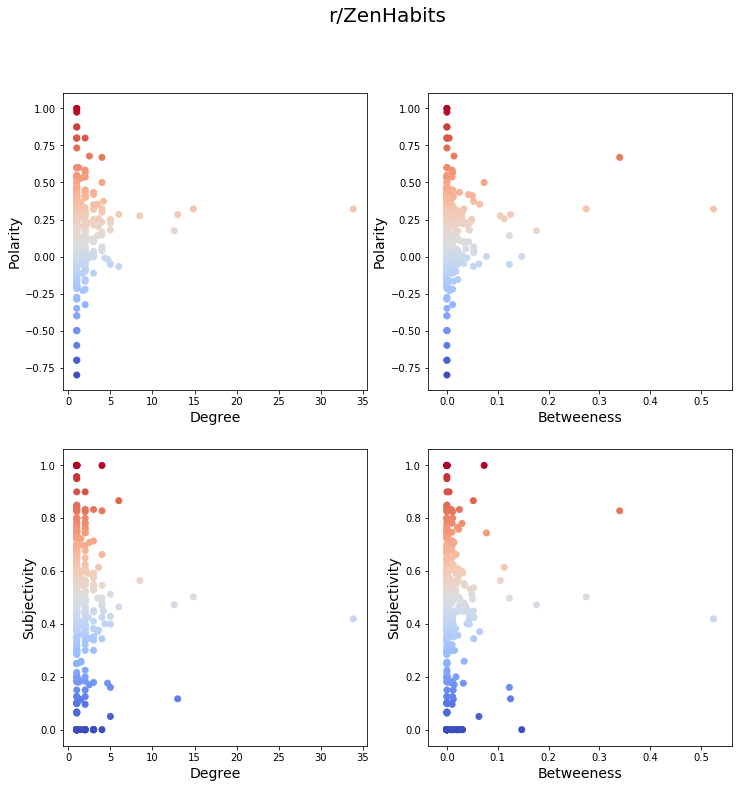

In [14]:
user_degree_avgPolarityZH = pickle.load(open('1w_ZenHabits_results.pkl', 'rb'))
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize = (12,12));
print("Average Polarity: "+ str(user_degree_avgPolarityZH["Polarity"].mean()))
print("Average Subjectivity: "+ str(user_degree_avgPolarityZH["Subjectivity"].mean()))
fig.suptitle("r/ZenHabits", fontsize=20);
#ax1 = fig.add_subplot(2,2,1) 
ax1.scatter(user_degree_avgPolarityZH['Degree'], user_degree_avgPolarityZH['Polarity'], c= user_degree_avgPolarityZH['Polarity'],cmap=cm.coolwarm)
ax2.scatter(user_degree_avgPolarityZH['Betweeness'], user_degree_avgPolarityZH['Polarity'], c= user_degree_avgPolarityZH['Polarity'],cmap=cm.coolwarm)
ax3.scatter(user_degree_avgPolarityZH['Degree'], user_degree_avgPolarityZH['Subjectivity'], c= user_degree_avgPolarityZH['Subjectivity'],cmap=cm.coolwarm)
ax4.scatter(user_degree_avgPolarityZH['Betweeness'], user_degree_avgPolarityZH['Subjectivity'], c= user_degree_avgPolarityZH['Subjectivity'],cmap=cm.coolwarm)

ax1.set_xlabel('Degree', fontsize=14)
ax1.set_ylabel('Polarity', fontsize=14)
ax2.set_xlabel('Betweeness', fontsize=14)
ax2.set_ylabel('Polarity', fontsize=14)

ax3.set_xlabel('Degree', fontsize=14)
ax3.set_ylabel('Subjectivity', fontsize=14);
ax4.set_xlabel('Betweeness', fontsize=14)
ax4.set_ylabel('Subjectivity', fontsize=14);


#cb = plt.colorbar(ax1, cax = cbaxes)
#hist(user_degree_avgPolarity.Degree, user_degree_avgPolarity.Polarity)
#user_degree_avgPolarity.hist('Degree')

<img src="1w_zenhabits.png" alt="Zen_Habits Network Visualization" width="600" height="600" align="left"/>

Average Polarity: 0.0839773762699104
Average Subjectivity: 0.39688714776172646


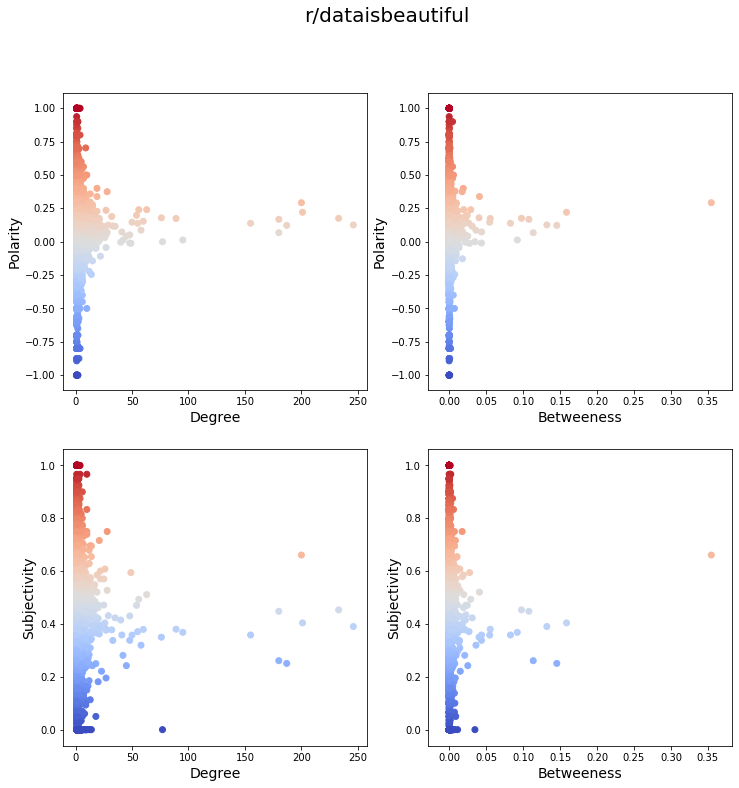

In [15]:
user_degree_avgPolarityC = pickle.load(open('1w_dataisbeautiful_results.pkl', 'rb'))
print("Average Polarity: "+ str(user_degree_avgPolarityC["Polarity"].mean()))
print("Average Subjectivity: "+ str(user_degree_avgPolarityC["Subjectivity"].mean()))
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize = (12,12))
fig.suptitle("r/dataisbeautiful", fontsize=20)

#ax1 = fig.add_subplot(2,2,1) 
ax1.scatter(user_degree_avgPolarityC['Degree'],user_degree_avgPolarityC['Polarity'], c= user_degree_avgPolarityC['Polarity'],cmap=cm.coolwarm)
ax2.scatter(user_degree_avgPolarityC ['Betweeness'], user_degree_avgPolarityC['Polarity'], c= user_degree_avgPolarityC ['Polarity'],cmap=cm.coolwarm)
ax3.scatter(user_degree_avgPolarityC ['Degree'], user_degree_avgPolarityC['Subjectivity'], c= user_degree_avgPolarityC['Subjectivity'],cmap=cm.coolwarm)
ax4.scatter(user_degree_avgPolarityC ['Betweeness'], user_degree_avgPolarityC['Subjectivity'], c= user_degree_avgPolarityC['Subjectivity'],cmap=cm.coolwarm)

ax1.set_xlabel('Degree', fontsize=14)
ax1.set_ylabel('Polarity', fontsize=14)
ax2.set_xlabel('Betweeness', fontsize=14)
ax2.set_ylabel('Polarity', fontsize=14)

ax3.set_xlabel('Degree', fontsize=14)
ax3.set_ylabel('Subjectivity', fontsize=14);
ax4.set_xlabel('Betweeness', fontsize=14)
ax4.set_ylabel('Subjectivity', fontsize=14);


<img src="1w_data.png" alt="DataIsBeautiful Network Visualization" width="600" height="600" align="left"/>

Average Polarity: 0.052156970045905214
Average Subjectivity: 0.3760156112237542


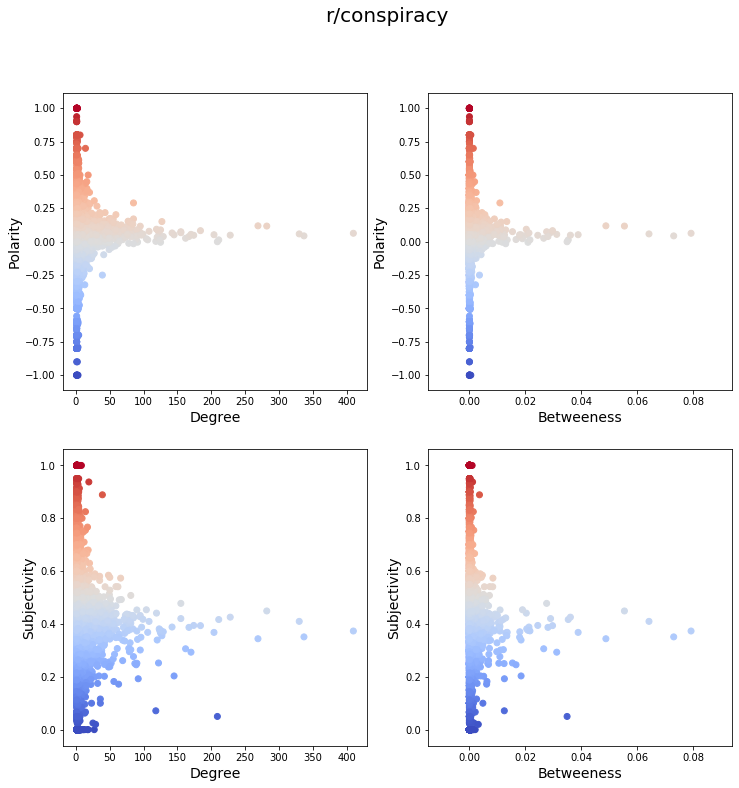

In [16]:
user_degree_avgPolarityC = pickle.load(open('1w_conspiracy_results.pkl', 'rb'))

print("Average Polarity: "+ str(user_degree_avgPolarityC["Polarity"].mean()))
print("Average Subjectivity: "+ str(user_degree_avgPolarityC["Subjectivity"].mean()))

fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize = (12,12))
fig.suptitle("r/conspiracy", fontsize=20)

#ax1 = fig.add_subplot(2,2,1) 
ax1.scatter(user_degree_avgPolarityC['Degree'],user_degree_avgPolarityC['Polarity'], c= user_degree_avgPolarityC['Polarity'],cmap=cm.coolwarm)
ax2.scatter(user_degree_avgPolarityC ['Betweeness'], user_degree_avgPolarityC['Polarity'], c= user_degree_avgPolarityC ['Polarity'],cmap=cm.coolwarm)
ax3.scatter(user_degree_avgPolarityC ['Degree'], user_degree_avgPolarityC['Subjectivity'], c= user_degree_avgPolarityC['Subjectivity'],cmap=cm.coolwarm)
ax4.scatter(user_degree_avgPolarityC ['Betweeness'], user_degree_avgPolarityC['Subjectivity'], c= user_degree_avgPolarityC['Subjectivity'],cmap=cm.coolwarm)

ax1.set_xlabel('Degree', fontsize=14)
ax1.set_ylabel('Polarity', fontsize=14)
ax2.set_xlabel('Betweeness', fontsize=14)
ax2.set_ylabel('Polarity', fontsize=14)

ax3.set_xlabel('Degree', fontsize=14)
ax3.set_ylabel('Subjectivity', fontsize=14);
ax4.set_xlabel('Betweeness', fontsize=14)
ax4.set_ylabel('Subjectivity', fontsize=14);

<img src="1w_conspiracy (2).png" alt="Conspiracy Network Visualization" width="600" height="600" align="left"/>

Average Polarity: 0.046021941944749054
Average Subjectivity: 0.38329059035479607


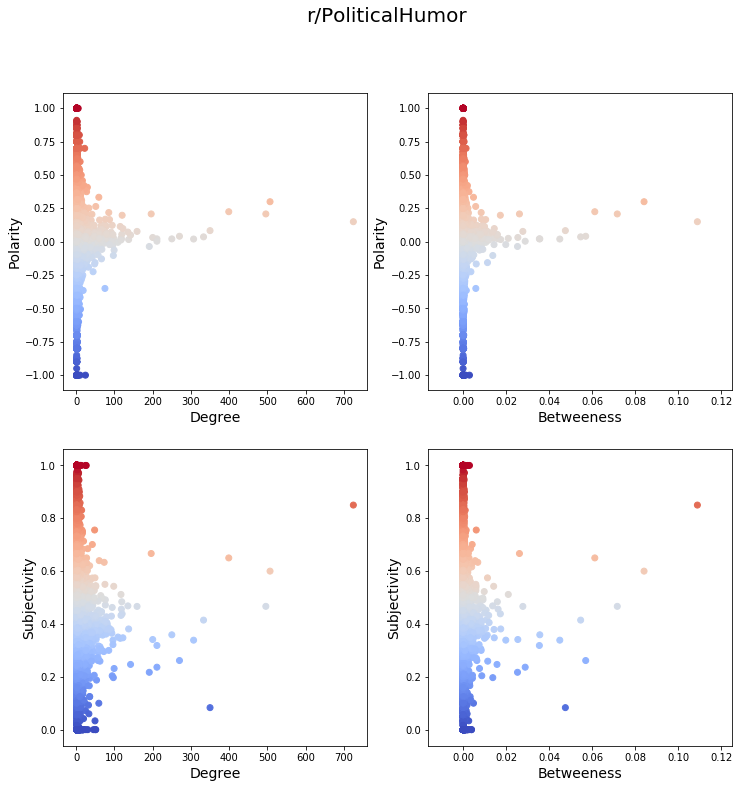

In [17]:
user_degree_avgPolarityPH = pickle.load(open('1w_polhumor_results.pkl', 'rb'))

print("Average Polarity: "+ str(user_degree_avgPolarityPH["Polarity"].mean()))
print("Average Subjectivity: "+ str(user_degree_avgPolarityPH["Subjectivity"].mean()))

fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize = (12,12))
fig.suptitle("r/PoliticalHumor", fontsize=20)
#ax1 = fig.add_subplot(2,2,1) 
ax1.scatter(user_degree_avgPolarityPH ['Degree'],user_degree_avgPolarityPH['Polarity'], c= user_degree_avgPolarityPH['Polarity'],cmap=cm.coolwarm)
ax2.scatter(user_degree_avgPolarityPH ['Betweeness'], user_degree_avgPolarityPH['Polarity'], c= user_degree_avgPolarityPH ['Polarity'],cmap=cm.coolwarm)
ax3.scatter(user_degree_avgPolarityPH ['Degree'], user_degree_avgPolarityPH['Subjectivity'], c= user_degree_avgPolarityPH ['Subjectivity'],cmap=cm.coolwarm)
ax4.scatter(user_degree_avgPolarityPH ['Betweeness'], user_degree_avgPolarityPH ['Subjectivity'], c= user_degree_avgPolarityPH ['Subjectivity'],cmap=cm.coolwarm)

ax1.set_xlabel('Degree', fontsize=14)
ax1.set_ylabel('Polarity', fontsize=14)
ax2.set_xlabel('Betweeness', fontsize=14)
ax2.set_ylabel('Polarity', fontsize=14)

ax3.set_xlabel('Degree', fontsize=14)
ax3.set_ylabel('Subjectivity', fontsize=14);
ax4.set_xlabel('Betweeness', fontsize=14)
ax4.set_ylabel('Subjectivity', fontsize=14);

<img src="1w_polhumor.png" alt="PoliticalHumor Network Visualization" width="600" height="600" align="left"/>

We were surprised by the results that we generated. We expected to see the most connected users to be more positive in the positive subreddits and more negative in the negative ones. What we found was that the most connected users seemed relatively moderate compared to the other users regardless of the base precieved positivity or negativity of the subreddit. 

The one outlier that to this trend was the political humor subreddit. It is known to be one of the subreddits with the highest levels of negativity and in this particular one the most connected users were not the most moderate and tended towards a higher level of polarity. 

On average the polarities for each of these subreddits was between 0 and 0.2 and the polarities of the most connected users were also around this level. 

Due to the time and resource contraints, this analysis was only conducted on a single weeklong sample for all of the subreddits we observed so it may not be true over all time scales. Further analysis into these trends over time, perhaps would reveal if a positive or negative preference in the most connected users is a leading indicator of the future sentiment of the entire subreddit community. 

In either case, the finding that the most connected users in this sample of subreddit communities tended to be more neutral than the communitiy as a whole, was interesting and counterintuitive. Data science techniques are a powerful tool to test and confirm our intuitions in areas like sentiment and toxicity in online communities. Given the relevance of these social network enviornements in modern life, ensuring that we have reasonable intuitions is crucial. This project has insprired us to use the data science skills gained throughout the course to further test and challenge assumptions about the world around us all!

<a id="#appendix"></a>
# Appendix


This segment of code compares the speed of interating through the generator directly versus using the list() method

In [22]:
start_epoch = dt.datetime(2019,1,1) + relativedelta(weeks=+0)
end_epoch = start_epoch+ relativedelta(weeks=+0) + relativedelta(weeks=+1)

# Uses Pushshift's API to get the list of posts in the given subreddit and timeframe
post_list = api.search_submissions(after=start_epoch, before = end_epoch, subreddit=tgt_sr )
count = 0 
t0 = time.time()
for i,post in enumerate(post_list):
    count +=1
#     if i <=10:
#         print(i)
#         print(post[-1]['author'])
print(count)
t1 = time.time()
total = t1-t0
print(str(total))

t0 = time.time()
post_list = list(api.search_submissions(after=start_epoch, before = end_epoch, subreddit=tgt_sr ))
print(len(post_list))
t1 = time.time()
total = t1-t0
print(str(total))

9
1.778111219406128
9
5.528105020523071


This method reads in the pickled `edge_df` and rebuilds the `gexf` file for visulaization in Gephi

<a id="#resources"></a>
# Resources and Citations


Progress Bar used to track code progress: https://www.mikulskibartosz.name/how-to-display-a-progress-bar-in-jupyter-notebook/</br>
Pushshift API: https://github.com/pushshift/api</br>
NetworkX: https://networkx.github.io/</br>
Sentiment Analysis: </br>
Gephi: https://gephi.org/ </br>
